# Section 1 

## Data Collection

For the F1 position based data i used the Jolpica API for season results, team standings, constructors points, and number of wins overall to determine the performance gaps.

For the financial data this required manual entry, web scraping proved to tricky as this data was not readily accessible in one format.

In [3]:
import requests 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, mannwhitneyu, ttest_ind, wilcoxon
import statsmodels.formula.api as smf
import math
import fastf1

In [8]:
def jolpica_retrieve(api_endpoint: str):
    url = f'https://api.jolpi.ca/ergast/f1/{api_endpoint}.json'
    response = requests.get(url)
    response.raise_for_status()
    return response.json()['MRData']

def get_constructor_standings(season: int):
    data = jolpica_retrieve(f'{season}/constructorStandings')
    standings = data['StandingsTable']['StandingsLists'][0]['ConstructorStandings']
    
    results = []
    for entry in standings:
        results.append({
            'Season': season,
            'Constructor': entry['Constructor']['name'],
            'Points': float(entry['points']),
            'Wins': int(entry['wins']),
            'Position': int(entry['position'])
        })
    
    return pd.DataFrame(results)

all_standings = pd.DataFrame()

for year in range(2018, 2024):
    df_standings = get_constructor_standings(year)
    all_standings = pd.concat([all_standings, df_standings], ignore_index=True)

print("Constructor Standings:")
all_standings.head()

Constructor Standings:
   Season  Constructor  Points  Wins  Position
0    2018     Mercedes   655.0    11         1
1    2018      Ferrari   571.0     6         2
2    2018     Red Bull   419.0     4         3
3    2018      Renault   122.0     0         4
4    2018  Force India   111.0     0         5


In [40]:
import pandas as pd

data = {
    "Season": [
        2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,
        2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,
        2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,
        2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,
        2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,
        2023,2023,2023,2023,2023,2023,2023,2023,2023,2023
    ],
    "Constructor": [
        "Williams","Toro Rosso","Sauber","Force India","Mclaren","Haas F1 Team","Renault","Redbull","Ferrari","Mercedes",
        "Williams","Toro Rosso","Alfa Romeo","Racing Point","Mclaren","Haas F1 Team","Renault","Redbull","Ferrari","Mercedes",
        "Williams","AlphaTauri","Alfa Romeo","Racing Point","Mclaren","Haas F1 Team","Renault","Redbull","Ferrari","Mercedes",
        "Williams","AlphaTauri","Alfa Romeo","Racing Point","Mclaren","Haas F1 Team","Renault","Redbull","Ferrari","Mercedes",
        "Williams","AlphaTauri","Alfa Romeo","Racing Point","Mclaren","Haas F1 Team","Renault","Redbull","Ferrari","Mercedes",
        "Williams","AlphaTauri","Alfa Romeo","Racing Point","Mclaren","Haas F1 Team","Renault","Redbull","Ferrari","Mercedes"
    ],
    "Budget (USD million)": [
        150,172,135,120,220,130,190,310,410,400,
        141,143,132,188,269,173,272,445,463,484,
        160,138,155,286,337,150,242,402,400,446,
        145,145,145,145,145,145,145,145,145,145,
        140,140,140,140,140,140,140,140,140,140,
        135,135,135,135,135,135,135,135,135,135
    ]
}

df_budgets = pd.DataFrame(data)

print("Input expenditure by Constructor from 2018 to 2023 (in millions of dollars)")
df_budgets.head()

Input expenditure by Constructor from 2018 to 2023 (in millions of dollars)
   Season  Constructor  Budget (USD million)
0    2018     Williams                   150
1    2018   Toro Rosso                   172
2    2018       Sauber                   135
3    2018  Force India                   120
4    2018      Mclaren                   220


# Section 2 

## Data Cleaning and Preparation for Analysis

The first step included aligning all the names to the 2023 Constructor Identities

In [43]:
name_map = {
    "Redbull": "Red Bull",       
    "Mclaren": "McLaren",
    "Ferrari": "Ferrari",
    "Mercedes": "Mercedes",
    "Williams": "Williams",
    "Haas F1 Team": "Haas",
    "Toro Rosso": "AlphaTauri",  
    "AlphaTauri": "AlphaTauri",  
    "Renault": "Alpine",
    "Alpine F1 Team":"Alpine",
    "Alpine": "Alpine",           
    "Sauber": "Alfa Romeo",       
    "Alfa Romeo": "Alfa Romeo",   
    "Force India": "Aston Martin",
    "Racing Point": "Aston Martin",
    "Aston Martin": "Aston Martin"
}

df_budgets["Constructor"] = df_budgets["Constructor"].replace(name_map)
all_standings["Constructor"] = all_standings["Constructor"].replace(name_map)

Team Classification dependent on average spending. Tier 1: Highest Spenders, Tier 2: Mid Spenders, Tier 3: Lowest Spenders.

Tier 1 (Mercedes, Ferrari, Red Bull), Tier 2 (McLaren, Alpine, Aston Martin), Tier 3 (AlphaTauri, Alfa Romeo, Williams, Haas)

In [44]:
tier_map = {
    "Ferrari": "High",
    "Mercedes": "High",
    "Red Bull": "High",
    "McLaren": "Mid",
    "Alpine": "Mid",
    "Aston Martin": "Mid",
    "Williams": "Low",
    "Haas": "Low",
    "Alfa Romeo": "Low",
    "AlphaTauri": "Low"
}

df_budgets["BudgetTier"] = df_budgets["Constructor"].map(tier_map)
df_budgets.head()

   Season   Constructor  Budget (USD million) BudgetTier
0    2018      Williams                   150        Low
1    2018    AlphaTauri                   172        Low
2    2018    Alfa Romeo                   135        Low
3    2018  Aston Martin                   120        Mid
4    2018       McLaren                   220        Mid


To analyse KPIs easier I merged both dataframes budget + performance

In [73]:
df_merged = pd.merge(
    df_budgets, 
    all_standings, 
    left_on=["Season", "Constructor"], 
    right_on=["Season", "Constructor"],
    how="inner"
)
df_merged = df_merged.drop(columns=["constructor"])
df_merged["BudgetEra"] = df_merged["Season"].apply(lambda x: "Pre-Cap" if x <= 2020 else "Post-Cap")

df_merged["Budget (USD million)"] = df_merged["Budget (USD million)"].astype(float)
df_merged["Points"] = df_merged["Points"].astype(float)
df_merged["Wins"] = df_merged["Wins"].astype(int)
df_merged["Position"] = df_merged["Position"].astype(int)
df_merged["Season"] = df_merged["Season"].astype(int)
df_merged["Constructor"] = df_merged["Constructor"].astype(str)
df_merged["BudgetTier"] = df_merged["BudgetTier"].astype(str)
df_merged["BudgetEra"] = df_merged["BudgetEra"].astype(str)

#print(df_merged.dtypes)
df_merged.head()

,Season,Constructor,Budget (USD million),BudgetTier,Points,Wins,Position,BudgetEra
0,2018,Williams,150.0,Low,7.0,0,10,Pre-Cap
1,2018,AlphaTauri,172.0,Low,33.0,0,9,Pre-Cap
2,2018,Alfa Romeo,135.0,Low,48.0,0,8,Pre-Cap
3,2018,Aston Martin,120.0,Mid,111.0,0,5,Pre-Cap
4,2018,McLaren,220.0,Mid,62.0,0,7,Pre-Cap


# Section 3 - Data Analysis and Data Visualisations

## KP1 - Points per Budget Tier (Pre- vs Post-Cap) per Constructor

In [48]:
tier_season_mean = df_merged.groupby(['Season','BudgetTier'], as_index=False)['Points'].mean()

prepost_tier_mean = df_merged.groupby(['BudgetEra','BudgetTier'], as_index=False)['Points'].mean()

team_era_means = (df_merged
                  .groupby(['Constructor','BudgetTier','BudgetEra'])['Points']
                  .mean()
                  .reset_index())

team_pivot = team_era_means.pivot(index='Constructor', columns='BudgetEra', values='Points').reset_index()

team_tier = team_era_means[['Constructor','BudgetTier']].drop_duplicates(subset=['Constructor'])
team_pivot = team_pivot.merge(team_tier, on='Constructor', how='left')

team_pivot.columns.name = None 
team_pivot = team_pivot.rename(columns={'Pre-Cap':'Pre', 'Post-Cap':'Post'})
team_pivot = team_pivot[['Constructor','Pre','Post','BudgetTier']]

team_pivot

,Constructor,Pre,Post,BudgetTier
0,Alfa Romeo,37.666667,28.000000,Low
1,AlphaTauri,75.000000,67.333333,Low
2,Alpine,131.333333,149.333333,Mid
3,Aston Martin,126.333333,137.333333,Mid
4,Ferrari,402.000000,427.833333,High
5,Haas,41.333333,16.333333,Low
6,McLaren,136.333333,245.333333,Mid
7,Mercedes,655.666667,512.500000,High
8,Red Bull,385.000000,734.833333,High
9,Williams,2.666667,19.666667,Low


In [60]:
print("Skewness of team-season Points by BudgetTier & Era")
for tier in df_merged['BudgetTier'].unique():
    for era in ['Pre-Cap','Post-Cap']:
        vals = df_merged[(df_merged['BudgetTier']==tier) & (df_merged['BudgetEra']==era)]['Points']
        if len(vals) > 0:
            print(tier, era, "n=", len(vals), "skew=", round(skew(vals),3))

Skewness of team-season Points by BudgetTier & Era
Low Pre-Cap n= 12 skew= 0.562
Low Post-Cap n= 12 skew= 2.24
Mid Pre-Cap n= 9 skew= 0.119
Mid Post-Cap n= 9 skew= 0.165
High Pre-Cap n= 9 skew= -0.502
High Post-Cap n= 9 skew= 0.409


**Low Pre-Cap n=12 skew=0.562**   -> Slightly right-skewed (a few higher than average point totals).

**Low Post-Cap n=12 skew=2.24**  -> Very right-skewed (most low-tier teams got few points, but 1–2 big outliers pulled far ahead).

**Mid Pre-Cap n=9 skew=0.119**    -> Very close to symmetric (normal-ish).

**Mid Post-Cap n=9 skew=0.165**   -> Also fairly symmetric.

**High Pre-Cap n=9 skew=-0.502**  -> Slightly left-skewed (a few teams underperformed relative to others).

**High Post-Cap n=9 skew=0.409**  -> Slightly right-skewed, but still manageable.

### The skew justifies using non-parametric tests like Mann–Whitney instead of t-tests.


In [59]:
for tier in ['High','Mid','Low']: 
    pre_vals = df_merged[(df_merged['BudgetTier']==tier) & (df_merged['BudgetEra']=='Pre-Cap')]['Points']
    post_vals = df_merged[(df_merged['BudgetTier']==tier) & (df_merged['BudgetEra']=='Post-Cap')]['Points']
    if len(pre_vals) and len(post_vals):
        stat, p = mannwhitneyu(pre_vals, post_vals, alternative='two-sided')
        print(tier, "Mann-Whitney p=", round(p,4), "n_pre=",len(pre_vals),"n_post=",len(post_vals))

High Mann-Whitney p= 0.5365 n_pre= 9 n_post= 9
Mid Mann-Whitney p= 0.3772 n_pre= 9 n_post= 9
Low Mann-Whitney p= 0.908 n_pre= 12 n_post= 12


**None of the changes are statistically significant at α = 0.05, likely due to small sample size (only 3 seasons pre vs 3 seasons post).**

In [57]:
for tier in ['High','Mid','Low']:
    subset = team_pivot[team_pivot['BudgetTier']==tier].dropna(subset=['Pre','Post'])
    if len(subset) < 2:
        continue
    diffs = subset['Post'] - subset['Pre']
    mean_diff = diffs.mean()
    sd_diff = diffs.std(ddof=1)
    cohen_d = mean_diff / sd_diff if sd_diff>0 else np.nan
    print(tier, "mean_diff=", round(mean_diff,2), "sd=", round(sd_diff,2), "cohen_d=", round(cohen_d,3))


High mean_diff= 77.5 sd= 250.53 cohen_d= 0.309
Mid mean_diff= 46.0 sd= 54.67 cohen_d= 0.841
Low mean_diff= -6.33 sd= 17.38 cohen_d= -0.364


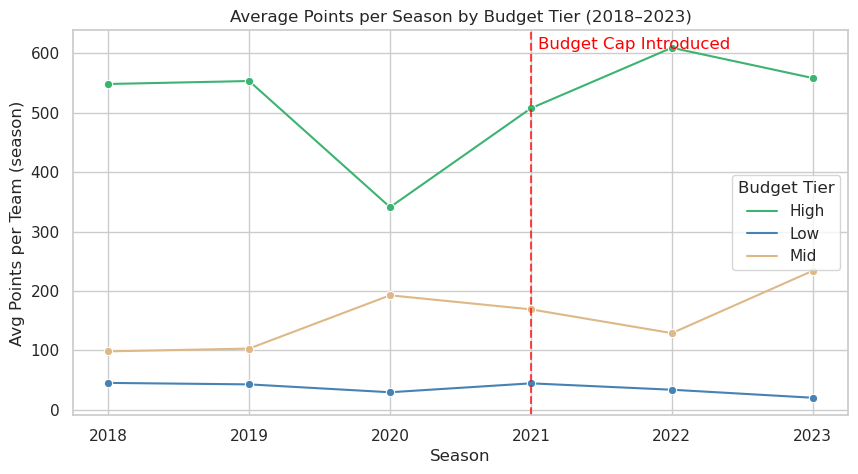

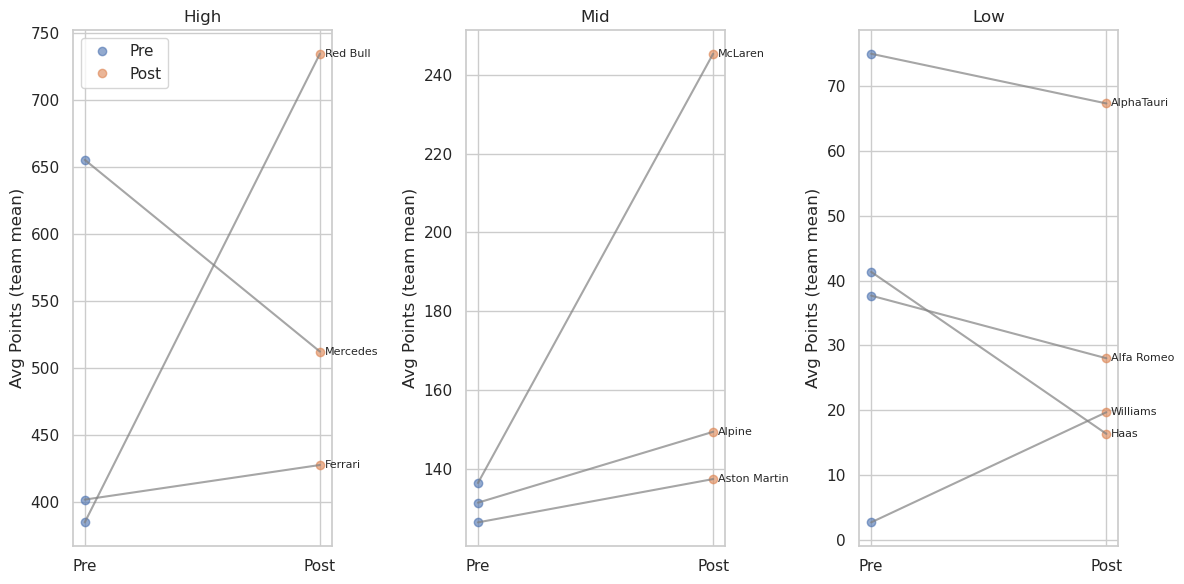

In [101]:
sns.set(style="whitegrid")

# line chart of mean points per season by BudgetTier

plt.figure(figsize=(10,5))
custom_palette = {
    'High': 'mediumseagreen',
    'Mid': 'burlywood',
    'Low': 'steelblue'
}

sns.lineplot(
    data=tier_season_mean, 
    x='Season', 
    y='Points', 
    hue='BudgetTier', 
    marker='o',
    palette=custom_palette
)

plt.title('Average Points per Season by Budget Tier (2018–2023)')
plt.ylabel('Avg Points per Team (season)')
plt.xticks(tier_season_mean['Season'].unique())
plt.legend(title='Budget Tier')

# Add budget cap vertical line + annotation
plt.axvline(x=2021, color='red', linestyle='--', alpha=0.7)
plt.text(2021+0.05, plt.ylim()[1]*0.95, 'Budget Cap Introduced', color='red')

plt.show()




# Paired dot plot for teams (visual paired differences)

plt.figure(figsize=(12,6))

for idx, tier in enumerate(['High','Mid','Low'], start=1):
    plt.subplot(1,3,idx)
    subset = team_pivot[team_pivot['BudgetTier']==tier].dropna(subset=['Pre','Post'])
    plt.plot([0]*len(subset), subset['Pre'], 'o', label='Pre', alpha=0.6)
    plt.plot([1]*len(subset), subset['Post'], 'o', label='Post', alpha=0.6)
    for i,row in subset.iterrows():
        plt.plot([0,1], [row['Pre'], row['Post']], '-', color='gray', alpha=0.7)
        plt.text(1.02, row['Post'], row['Constructor'], fontsize=8, va='center')
    
    plt.title(tier)
    plt.xticks([0,1], ['Pre','Post'])
    plt.ylabel('Avg Points (team mean)')
    if idx==1:  
        plt.legend()

plt.tight_layout()
plt.show()


### PI 1: Points per Budget Tier (Pre vs Post-Cap)

High: Mean ↑ 77.5 pts (small effect, d=0.31, p=0.54)<br>
Mid: Mean ↑ 46 pts (large effect, d=0.84, p=0.38)<br>
Low: Mean ↓ 6.3 pts (small negative, d=-0.36, p=0.91)<br>

**Conclusion: Mid-tier teams gained most post-cap, though results are not statistically significant due to small sample size.**

## KPI2 - Budget Efficiency 

I'm defining efficiency as points per million USD spent.

In [84]:
df_merged['Efficiency'] = df_merged['Points'] / df_merged['Budget (USD million)']

tier_eff = df_merged.groupby(['BudgetTier','BudgetEra'])['Efficiency'].mean().reset_index()

team_eff = df_merged.groupby(['Constructor','BudgetTier'])['Efficiency'].mean().reset_index().sort_values('Efficiency', ascending=False)


,BudgetTier,BudgetEra,Efficiency
0,High,Post-Cap,3.996061
1,High,Pre-Cap,1.148897
2,Low,Post-Cap,0.232656
3,Low,Pre-Cap,0.279301
4,Mid,Post-Cap,1.273426
5,Mid,Pre-Cap,0.571108


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


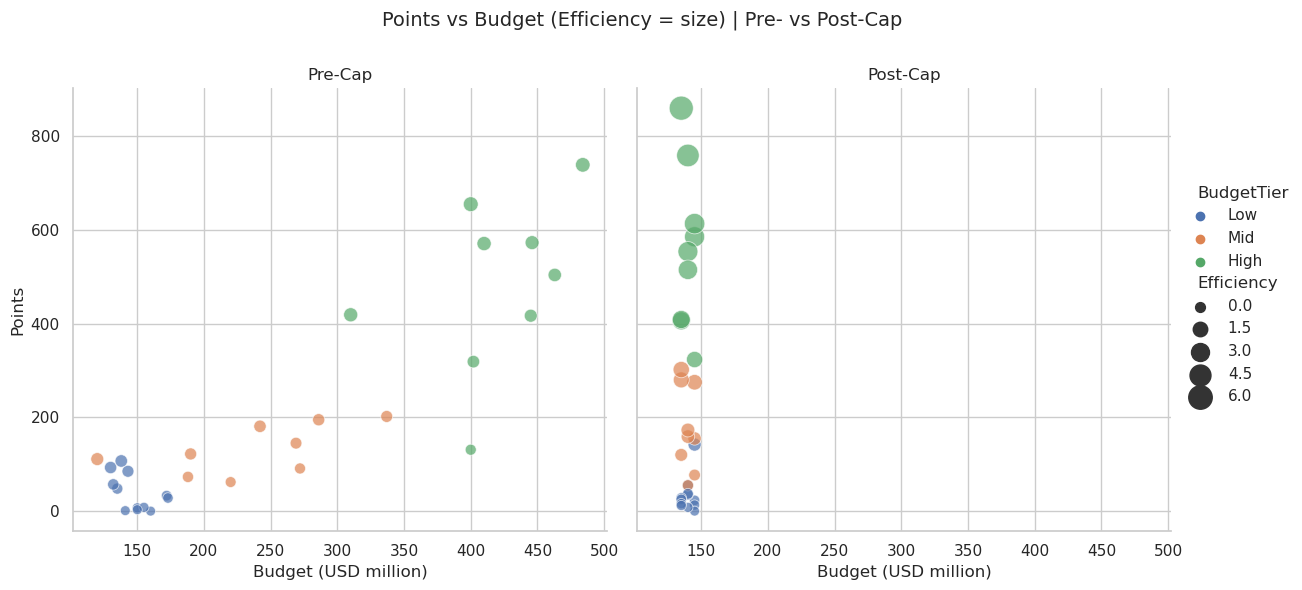

In [104]:
custom_palette = {
    'High': 'mediumseagreen',
    'Mid': 'steelblue',
    'Low': 'burlywood'
}

g = sns.relplot(
    data=df_merged,
    x='Budget (USD million)',
    y='Points',
    hue='BudgetTier',
    size='Efficiency',
    sizes=(50, 300),
    alpha=0.7,
    col='BudgetEra',   
    height=6,
    aspect=1
)

g.set_axis_labels("Budget (USD million)", "Points")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Points vs Budget (Efficiency = size) | Pre- vs Post-Cap", fontsize=14)
plt.show()


**Pre-cap (2018–2020):** Clear spread in budgets -> high teams (Mercedes, Ferrari, Red Bull) far to the right with huge budgets and huge points. Mid- and low-tier teams spread out lower down, with some “punching above weight.”

**Post-cap (2021–2023):** Everyone clusters around ~$135–145M (the budget cap line). But the hierarchy still remains -> high-tier teams sit far higher in points, while mid/low remain below, though efficiency (bubble size) looks bigger for most mid-tier and high-tier teams.

This proves the structural point: budgets converged, but performance didn’t.

### KPI3 - Outlier Dominance

In [110]:
season_totals = df_merged.groupby('Season')['Points'].sum().reset_index().rename(columns={'Points':'TotalPoints'})

df_points_share = df_merged.merge(season_totals, on='Season')
df_points_share['PointsShare'] = df_points_share['Points'] / df_points_share['TotalPoints'] * 100
df_points_share = df_points_share[['Season','Constructor','Points','Wins','Position','TotalPoints','PointsShare']]

,Season,Group,PointsShare
0,2018,Rest,22.442244
1,2018,Top 3,77.557756
2,2019,Rest,22.429907
3,2019,Top 3,77.570093
4,2020,Rest,40.488656
5,2020,Top 3,59.511344
6,2021,Rest,31.030578
7,2021,Top 3,68.969422
8,2022,Rest,22.212766
9,2022,Top 3,77.787234


In [123]:
df_points_share['Group'] = df_points_share['Constructor'].apply(
    lambda x: x if x in ['Red Bull','Mercedes','Ferrari'] else 'Other'
)
df_points_grouped = df_points_share.groupby(['Season','Group'], as_index=False)['PointsShare'].sum()
df_points_pivot = df_points_grouped.pivot(index='Season', columns='Group', values='PointsShare').fillna(0)

df_wins = df_merged.groupby(['Season','Constructor'], as_index=False)['Wins'].sum()
season_totals_wins = df_wins.groupby('Season')['Wins'].sum().reset_index(name='TotalWins')
df_wins = df_wins.merge(season_totals_wins, on='Season')
df_wins['WinShare'] = df_wins['Wins'] / df_wins['TotalWins'] * 100
df_wins['Group'] = df_wins['Constructor'].apply(
    lambda x: x if x in ['Red Bull','Mercedes','Ferrari'] else 'Other'
)
df_wins_grouped = df_wins.groupby(['Season','Group'], as_index=False)['WinShare'].sum()
df_wins_pivot = df_wins_grouped.pivot(index='Season', columns='Group', values='WinShare').fillna(0)

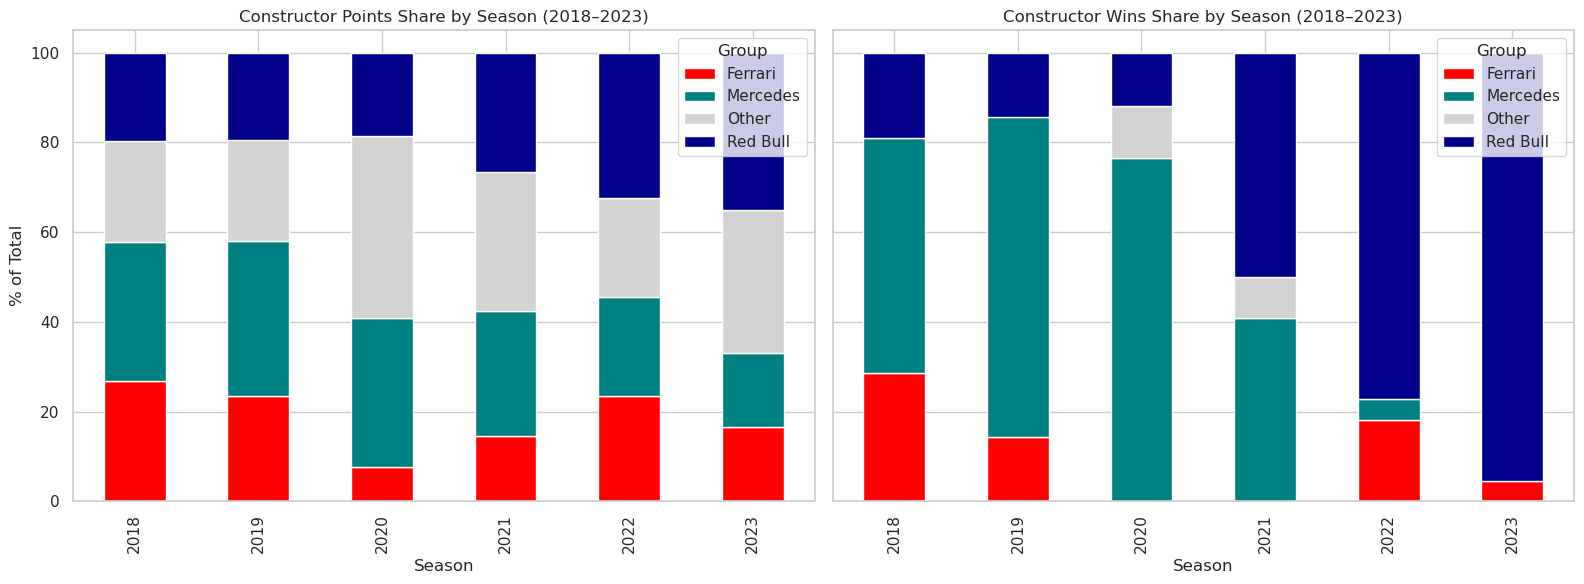

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

df_points_pivot.plot(
    kind='bar', stacked=True, ax=axes[0],
    color={'Red Bull':'darkblue','Mercedes':'teal','Ferrari':'red','Other':'lightgray'}
)
axes[0].set_title('Constructor Points Share by Season (2018–2023)')
axes[0].set_ylabel('% of Total')
axes[0].set_xlabel('Season')

df_wins_pivot.plot(
    kind='bar', stacked=True, ax=axes[1],
    color={'Red Bull':'darkblue','Mercedes':'teal','Ferrari':'red','Other':'lightgray'}
)
axes[1].set_title('Constructor Wins Share by Season (2018–2023)')
axes[1].set_ylabel('')
axes[1].set_xlabel('Season')

plt.tight_layout()
plt.show()



The graph effectively highlights Red Bull's exceptional dominance, even after the implementation of the F1 budget cap. While the cap has theoretically leveled the playing field by limiting spending on car development, the visual shows Red Bull as a clear outlier, achieving significantly more points for a similar budget compared to their competitors. This suggests that their advantage stems from a "legacy" of pre-cap investments in top-tier personnel, advanced infrastructure, and a well-established operational efficiency that allows them to extract maximum performance from their capped resources, thereby outperforming rivals who are financially on par.